# Gallery of Harmonic Oscillators and Friends

All the oscillators explored here are special cases of the [*Duffing Oscillator*](https://en.wikipedia.org/wiki/Duffing_equation)

$$ \ddot{x} + 2\beta \dot{x} + \omega_0^2 x + \alpha x^3 = D \cos(\delta t) $$

where $\beta$ is the damping coefficient, $\omega_0$ is the system's "natural frequency", $\alpha$ is the non-linearity coefficient, $D$ is the amplitude of the driving force, and $\delta$ is the frequency of the driving force.

## Infrastructure Code

In [1]:
# Imports:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
from warnings import warn

# Constants:
PLOT_SIZE = 10, 2
AMP_PLOT_SIZE = 8, 6
ROUNDOFF_MARGIN = 1e-12
TRANSIENT_MULTIPLIER = 10
DEFAULT_TIMESTEP_FRACTION = 256

### Oscillator model

In [2]:
# Define a class for a harmonic driving force.
class HarmonicDriver():
    def __init__(self, amplitude, angular_frequency, phase=0):
        self.amplitude = amplitude
        self.angular_frequency = angular_frequency
        self.phase = phase

    def __call__(self, t):
        return self.amplitude * np.sin(self.angular_frequency * t + self.phase)

In [3]:
# Define a class for a driver that smoothly changes from one driving frequency to another.
class TransitionDriver():
    def __init__(self, amplitude, freq_1, freq_2, transition_time, phase=0):
        self.amplitude = amplitude
        self.freq_1 = freq_1
        self.freq_2 = freq_2
        self.transition_time = transition_time
        self.phase = phase
        self.t_1 = None
        self.t_2 = None

    def __call__(self, t):
        if not self.t_1:
            self.t_1 = t
            self.t_2 = t + self.transition_time
        current_freq = self.freq_1 + (self.freq_2 - self.freq_1) * (t - self.t_1) / self.transition_time
        return self.amplitude * np.sin(current_freq * t + self.phase)

In [4]:
# Define a class for the derivative function (the acceleration).
class DerivativeFunction():
    def __init__(self, parameters):
        self.Bx2 = 2.0 * float(parameters['beta'])
        self.w0 = float(parameters['omega_0'])
        self.a = float(parameters['alpha'])
        
    def __call__(self, v, x, t, driver):
        return driver(t) - self.Bx2 * v - self.w0**2 * x - self.a * x**3

In [5]:
# Define a class to represent an oscillator.
class Oscillator():
    
    def __init__(self, parameters, x0, v0, driver=None):
        self.parameters = parameters
        self.v0 = v0
        self.x0 = x0
        self.v = v0
        self.x = x0
        self.t = 0.0
        self.dv_dt = DerivativeFunction(parameters)
        if driver:
            self.driver = driver
        elif ('D' in parameters) and ('d' in parameters):
            self.driver = HarmonicDriver(parameters['D'], parameters['d'])
        else:
            self.driver = lambda t: 0.0
    
    def update_parameters(self, new_parameters):
        self.parameters = new_parameters
        self.dv_dt = dv_dt(new_parameters)
        return self
    
    def reset(self):
        self.v = self.v0
        self.x = self.x0
        self.t = 0.0
        return self
    
    def set_driver(self, driver):
        if driver:
            self.driver = driver
        else:
            self.driver = lambda t: 0.0
        return self
        
    def step(self, dt):
        ''' An Euler-Cromer update step, with the velocity at t+dt calculated
            from the system's state at t, and the poisition at t+dt calculated
            from the updated velocity at t+dt. The calculated velocity and
            position are considered to be the system's values at time t+dt.
        '''
        self.v += self.dv_dt(self.v, self.x, self.t, self.driver) * dt
        self.x += self.v * dt
        self.t += dt
        return self.t, self.x, self.v
    
    def choose_timestep(self):
        """ Pick a timestep that is small compared to the driving force's period
            and the oscillator's natural period.
        """
        try:
            max_freq = max(self.driver.angular_frequency, self.parameters['omega_0'])
        except AttributeError:
            max_freq = self.parameters['omega_0']
        min_period = 2.0 * np.pi / max_freq
        return min_period / DEFAULT_TIMESTEP_FRACTION

    def run(self, T, dt = None):
        # Run multiple update steps for a given duration, returning the
        # intermediate values as an iterator.
        if not dt:
            dt = self.choose_timestep()
        t_i = self.t
        t_f = t_i + T - dt + ROUNDOFF_MARGIN
        while self.t < t_f:
            yield self.step(dt)
    
    def record(self, T, dt = None):
        # Run multiple update steps for a given duration, returning arrays of
        # t, x, and v at each step, including the starting values.
        if not dt:
            dt = self.choose_timestep()
        t_values = np.zeros(int((T + ROUNDOFF_MARGIN) // dt) + 1)
        x_values = np.zeros_like(t_values)
        v_values = np.zeros_like(t_values)
        t_values[0], x_values[0], v_values[0] = self.t, self.x, self.v
        i = 1
        for (t, x, v) in self.run(T, dt):
            t_values[i], x_values[i], v_values[i] = t, x, v
            i += 1
        return t_values, x_values, v_values

    def transient_time(self):
        """ Estimates the time required for an initial transient to die away.
        """
        # Check that the oscillator is damped.
        if self.parameters['beta'] == 0:
            warn("Can't calculate transient time because oscillator is undamped (beta = 0).")
            return None
            # raise ValueError('Oscillator is undamped (beta = 0).')
        # Check that the oscillator is underdamped.
        if self.parameters['beta'] >= self.parameters['omega_0']:
            raise ValueError('Oscillator is not underdamped (beta < omega_0).')
        # Allow a set number of "time constants" to pass for the transient to
        # become negligibly small.
        # try:
        #     max_freq = max(self.driver.angular_frequency, self.parameters['omega_0'])
        # except AttributeError:
        #     max_freq = self.parameters['omega_0']
        # min_period = 2.0 * np.pi / max_freq
        return TRANSIENT_MULTIPLIER / self.parameters['beta']
        
    def pass_transient(self):
        """ Evolve for enough time to allow the initial transient to die away.
        """
        for _ in self.run(self.transient_time()):
            pass
        
    def attractor_amplitude(self, skip_transient=True):
        """ Determines the amplitude of the steady-state oscillations that the
            given oscillator settles into after its transient dies away.
        """
        if skip_transient and self.transient_time():
            self.pass_transient()
        try:
            min_freq = min(self.driver.angular_frequency, self.parameters['omega_0'])
        except AttributeError:
            min_freq = self.parameters['omega_0']
        max_period = 2.0 * np.pi / min_freq
        _, x_values, _ = self.record(5 * max_period)
        return (max(x_values) - min(x_values)) / 2.0

            


### Utility functions

In [6]:
# Helper function to plot trajectories
def plot_trajectory(t, x, v = None):
    fig, ax_left = plt.subplots(figsize=PLOT_SIZE)
    ax_left.plot(t, x, label='x')
    ax_left.margins(x = 0)
    ax_left.grid()
    ax_left.set_xlabel('time, t')
    ax_left.set_ylabel('position, x')
    if v:
        ax_right = ax_left.twinx()
        ax_right.plot(t, v, label='v', color='purple')
        ax_right.set_ylabel('velocity, v')
    plt.show()

In [7]:
# Helper function to plot an amplitude curve
def plot_amplitude_curve(freq_ratios, amplitudes):
    fig, ax_left = plt.subplots(figsize=AMP_PLOT_SIZE)
    ax_left.plot(freq_ratios, amplitudes, '.')
    ax_left.margins(x = 0)
    ax_left.grid()
    ax_left.set_xlabel(r"driving frequency / natural frequency ($\delta / \omega_0$)")
    ax_left.set_ylabel("attractor amplitude")
    plt.show()

In [8]:
# Helper function to plot multiple amplitude curves
def plot_amplitude_curves(freq_ratios, amplitude_curves, line_type='.', log_y=False):
    fig, ax = plt.subplots(figsize=AMP_PLOT_SIZE)
    for label, amplitudes in amplitude_curves.items():
        ax.plot(freq_ratios, amplitudes, line_type, label=label)
    ax.margins(x = 0)
    ax.grid()
    ax.set_xlabel(r"driving frequency / natural frequency ($\delta / \omega_0$)")
    ax.set_ylabel("attractor amplitude")
    if log_y:
        ax.set_yscale('log')
    ax.legend()
    plt.show()

### Testing area

transient time = 20.0.


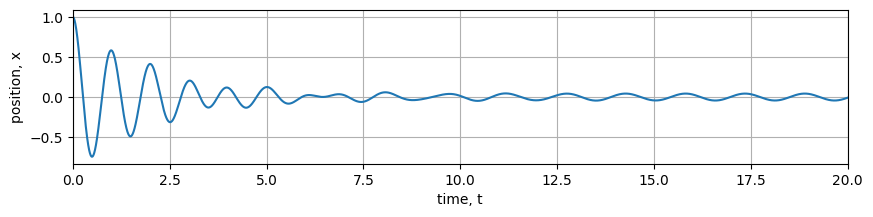

attractor amplitude = 0.04311443322531703.


In [9]:
# Testing area
params = {"beta": 0.5, "omega_0": 2 * np.pi, "alpha":0.0 }
x0, v0 = 1.0, 0.0
T = 20
osc = Oscillator(params, x0 = x0, v0 = v0, driver = HarmonicDriver(1.0, 1.3 * np.pi))
print(f"transient time = {osc.transient_time()}.")
t, x, v = osc.record(T)
plot_trajectory(t, x)
print(f"attractor amplitude = {osc.attractor_amplitude()}.")

---

## SHO: Simple Harmonic Oscillator

transient time = None.


/var/folders/03/bz532zzx1lb2z3vsyy6281qr0000gr/T/ipykernel_84031/2713867574.py:89: UserWarning: Can't calculate transient time because oscillator is undamped (beta = 0).
  warn("Can't calculate transient time because oscillator is undamped (beta = 0).")


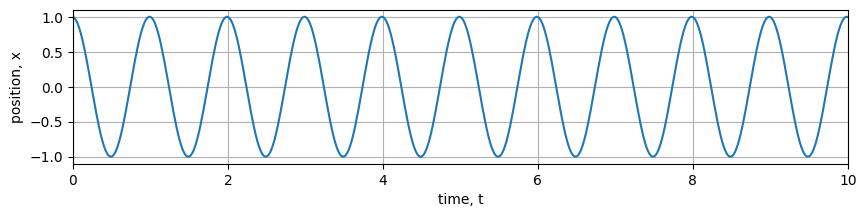

attractor amplitude = 0.9979708230588122.


In [10]:
params = {"beta": 0, "omega_0": 2 * np.pi, "alpha": 0.0 }
x0, v0 = 1.0, 0.0
T, dt = 10, 0.02
osc = Oscillator(params, x0 = x0, v0 = v0, driver = None)
print(f"transient time = {osc.transient_time()}.")
t, x, v = osc.record(T, dt)
plot_trajectory(t, x)
print(f"attractor amplitude = {osc.attractor_amplitude()}.")

---

## DHO: Damped Harmonic Oscillator

### Overdamped: $\beta > \omega_0$

#### Starting from rest away from equilibrium:

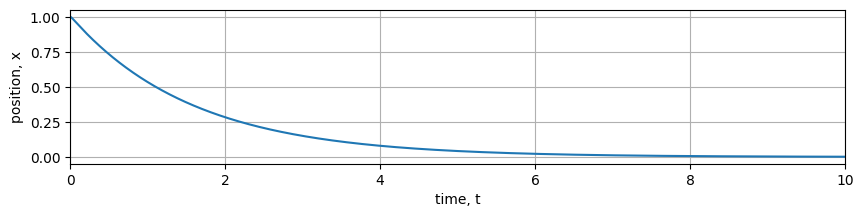

In [11]:
params = {"beta": 10 * np.pi, "omega_0": 2 * np.pi, "alpha":0.0 }
x0, v0 = 1.0, 0.0
T = 10
osc = Oscillator(params, x0 = x0, v0 = v0)
t, x, v = osc.record(T)
plot_trajectory(t, x)

#### Starting in motion at equilibrium:

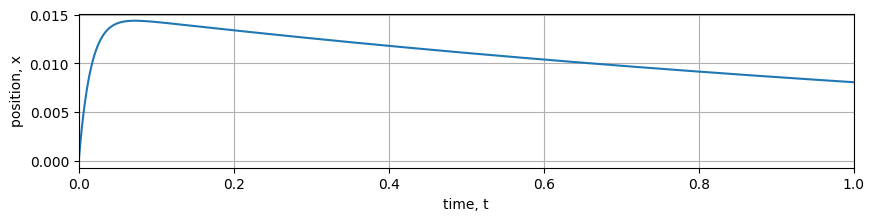

In [12]:
params = {"beta": 10 * np.pi, "omega_0": 2 * np.pi, "alpha":0.0 }
x0, v0 = 0.0, 1.0
T, dt = 1, 0.001
osc = Oscillator(params, x0 = x0, v0 = v0, driver = None)
t, x, v = osc.record(T, dt)
plot_trajectory(t, x)

### Underdamped: $\beta < \omega_0$

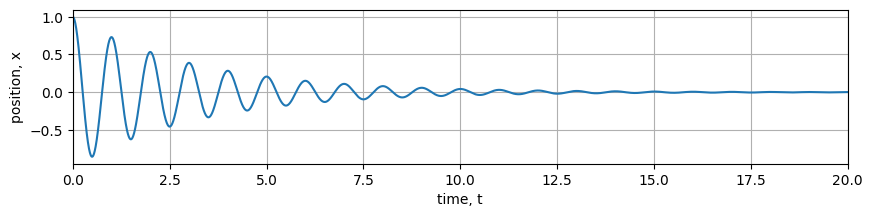

In [13]:
params = {"beta": 0.1 * np.pi, "omega_0": 2 * np.pi, "alpha":0.0 }
x0, v0 = 1.0, 0.0
T = 20
osc = Oscillator(params, x0 = x0, v0 = v0)
t, x, v = osc.record(T)
plot_trajectory(t, x)

### Critically damped: $\beta = \omega_0$

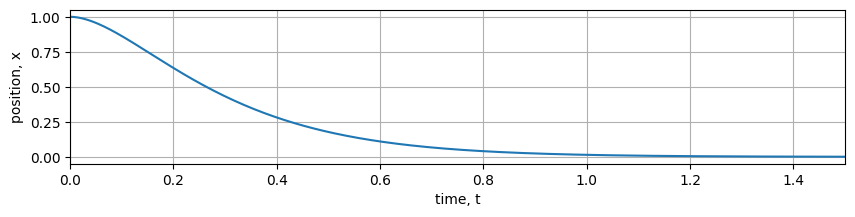

In [14]:
params = {"beta": 2 * np.pi, "omega_0": 2 * np.pi, "alpha":0.0 }
x0, v0 = 1.0, 0.0
T = 1.5
osc = Oscillator(params, x0 = x0, v0 = v0)
t, x, v = osc.record(T)
plot_trajectory(t, x)

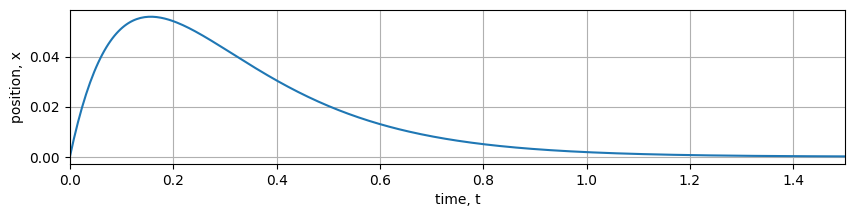

In [15]:
params = {"beta": 2 * np.pi, "omega_0": 2 * np.pi, "alpha":0.0 }
x0, v0 = 0.0, 1.0
T = 1.5
osc = Oscillator(params, x0 = x0, v0 = v0)
t, x, v = osc.record(T)
plot_trajectory(t, x)

---

## DDHO: Damped Driven Harmonic Oscillator

### Example of transient and attractor:

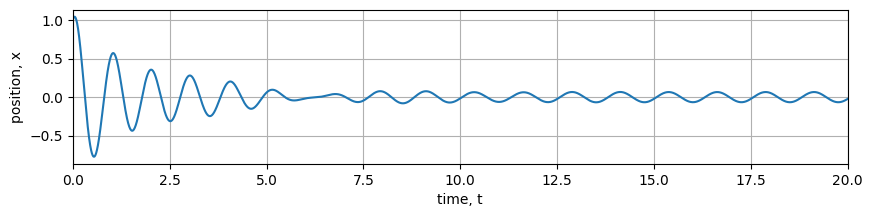

attractor amplitude = 0.06612743673453081.


In [16]:
params = {"beta": 0.5, "omega_0": 2 * np.pi, "alpha":0.0 }
x0, v0 = 1.0, 2.0
T = 20
osc = Oscillator(params, x0 = x0, v0 = v0, driver = HarmonicDriver(1.0, 1.6 * np.pi))
t, x, v = osc.record(T)
plot_trajectory(t, x)
print(f"attractor amplitude = {osc.attractor_amplitude()}.")

With a different initial condition:

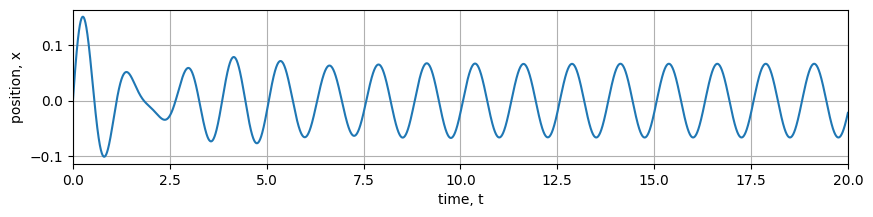

attractor amplitude = 0.06612743659050316.


In [17]:
x0, v0 = 0.0, 1.0
osc = Oscillator(params, x0 = x0, v0 = v0, driver = HarmonicDriver(1.0, 1.6 * np.pi))
t, x, v = osc.record(T)
plot_trajectory(t, x)
print(f"attractor amplitude = {osc.attractor_amplitude()}.")

### Attractor amplitude vs. driving frequency:

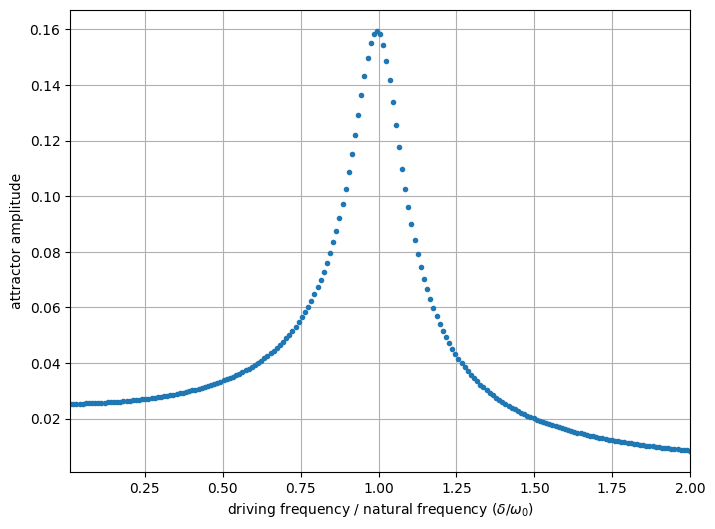

In [18]:
params = {"beta": 0.5, "omega_0": 2 * np.pi, "alpha":0.0 }
x0, v0 = 1.0, 0.0
osc = Oscillator(params, x0 = x0, v0 = v0)
natural_frequency = osc.parameters['omega_0']
frequencies = np.linspace(0, natural_frequency * 2, 200)[1:]
amplitudes = np.zeros_like(frequencies)
for i, f in enumerate(frequencies):
    osc.set_driver(HarmonicDriver(1.0, f))
    amplitudes[i] = osc.attractor_amplitude()
freq_ratios = frequencies / osc.parameters['omega_0']
plot_amplitude_curve(freq_ratios, amplitudes)

### Effect of damping coefficient on attractor amplitude:

Caculating amplitude curve for beta = 0.5…
Caculating amplitude curve for beta = 0.2…
Caculating amplitude curve for beta = 0.05…
Caculating amplitude curve for beta = 0.02…
Caculating amplitude curve for beta = 0.005…


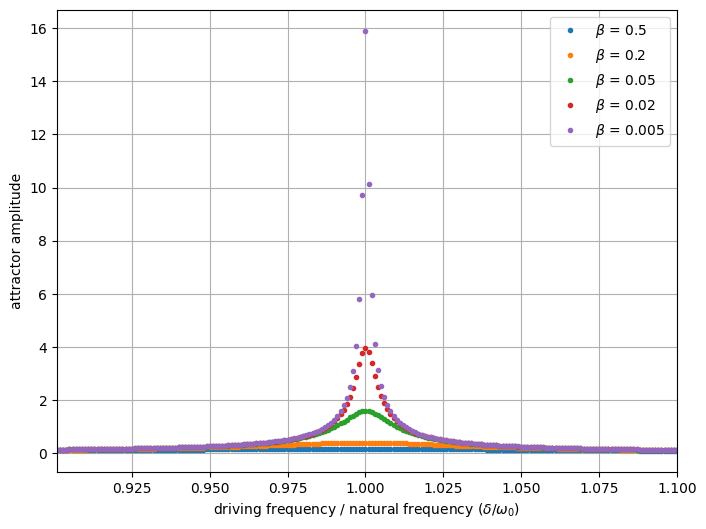

In [17]:
beta_values = [0.5, 0.2, 0.05, 0.02, 0.005]
params = {"beta": None, "omega_0": 2 * np.pi, "alpha":0.0 }
x0, v0 = 1.0, 0.0
natural_frequency = params['omega_0']
frequencies = np.linspace(0.9 * natural_frequency, 1.1 * natural_frequency, 201)[1:]
freq_ratios = frequencies / natural_frequency
amplitude_curves = {}
for beta in beta_values:
    print(f"Caculating amplitude curve for beta = {beta}…")
    params["beta"] = beta
    osc = Oscillator(params, x0 = x0, v0 = v0)
    amplitudes = np.zeros_like(frequencies)
    for i, f in enumerate(frequencies):
        osc.set_driver(HarmonicDriver(1.0, f))
        amplitudes[i] = osc.attractor_amplitude()
    amplitude_curves[fr"$\beta$ = {beta}"] = amplitudes
plot_amplitude_curves(freq_ratios, amplitude_curves)

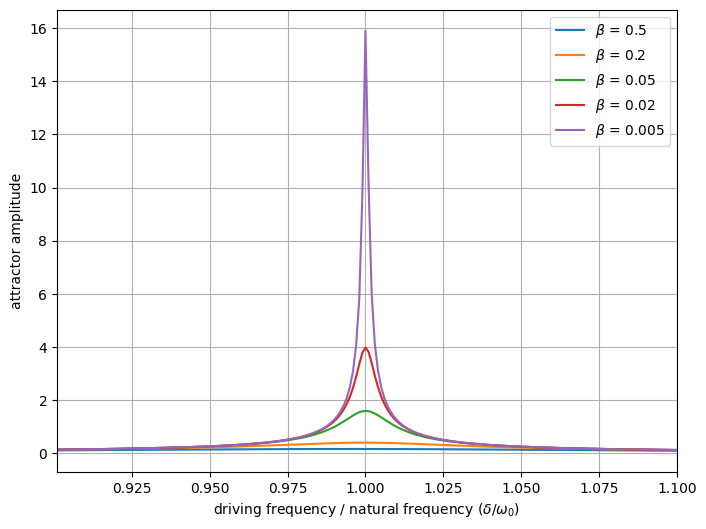

In [19]:
plot_amplitude_curves(freq_ratios, amplitude_curves, line_type='-')

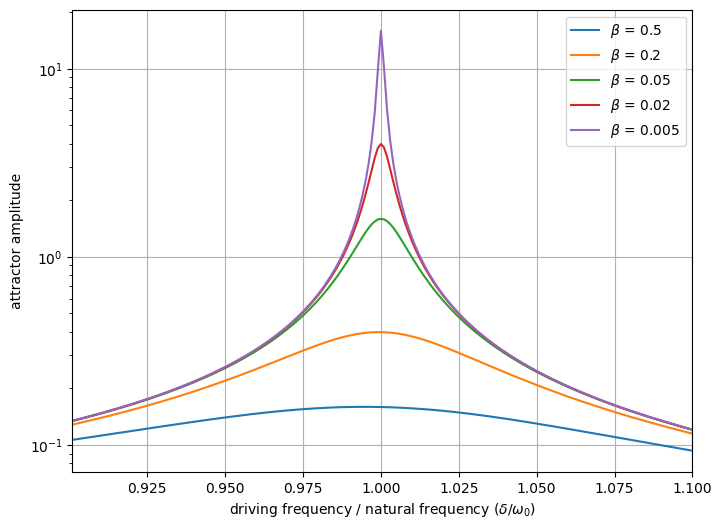

In [21]:
plot_amplitude_curves(freq_ratios, amplitude_curves, line_type='-', log_y=True)

## Nonlinear Oscillator

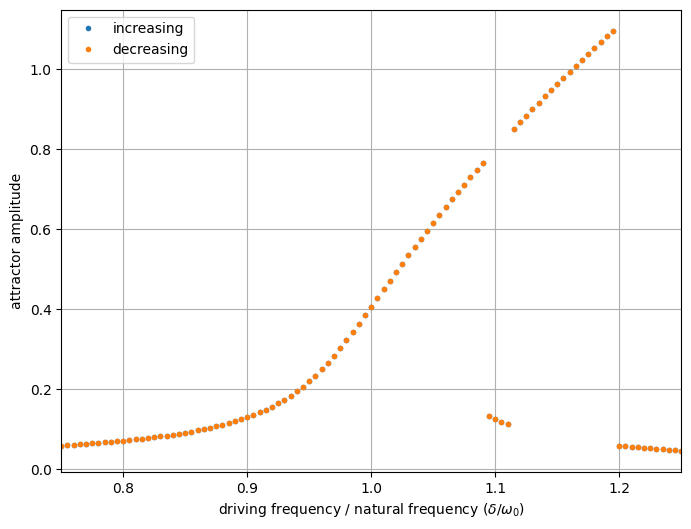

In [62]:
params = {"beta": 0.02, "omega_0": 2 * np.pi, "alpha":20.0 }
x0, v0 = 1.0, 0.0
osc = Oscillator(params, x0 = x0, v0 = v0)
natural_frequency = osc.parameters['omega_0']
n_points = 101
frequencies = np.linspace(0.75 * natural_frequency, 1.25 * natural_frequency, n_points)
amplitude_curves = {}
amplitudes = np.zeros_like(frequencies)
for i, f in enumerate(frequencies):
    osc.set_driver(HarmonicDriver(1.0, f))
    amplitudes[i] = osc.attractor_amplitude()
amplitude_curves["increasing"] = amplitudes
amplitudes = np.zeros_like(frequencies)
for i, f in enumerate(reversed(frequencies)):
    osc.set_driver(HarmonicDriver(1.0, f))
    amplitudes[n_points - i - 1] = osc.attractor_amplitude()
amplitude_curves["decreasing"] = amplitudes
freq_ratios = frequencies / osc.parameters['omega_0']
plot_amplitude_curves(freq_ratios, amplitude_curves)

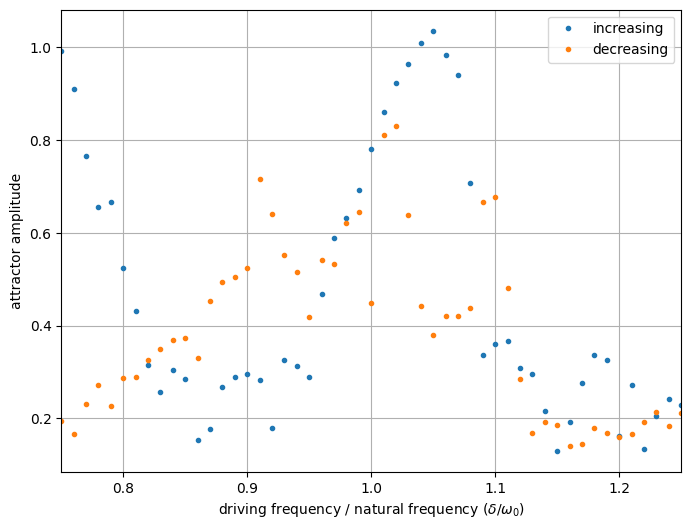

In [19]:
params = {"beta": 0.02, "omega_0": 2 * np.pi, "alpha":20.0 }
x0, v0 = 1.0, 0.0
osc = Oscillator(params, x0 = x0, v0 = v0)
natural_frequency = osc.parameters['omega_0']
n_points = 51
frequencies = np.linspace(0.75 * natural_frequency, 1.25 * natural_frequency, n_points)
amplitude_curves = {}
amplitudes = np.zeros_like(frequencies)
for i in range(len(frequencies)):
    f_new = frequencies[i]
    if i > 0:
        f_old = frequencies[i-1]
        transition_time = 2000.0 * np.pi / f_new
        osc.set_driver(TransitionDriver(1.0, f_old, f_new, transition_time))
    osc.set_driver(HarmonicDriver(1.0, f_new))
    amplitudes[i] = osc.attractor_amplitude(skip_transient=False)
amplitude_curves["increasing"] = amplitudes
amplitudes = np.zeros_like(frequencies)
for i in range(len(frequencies), 0, -1):
    f_new = frequencies[i-1]
    if i < len(frequencies):
        f_old = frequencies[i]
        transition_time = 2000.0 * np.pi / f_new
        osc.set_driver(TransitionDriver(1.0, f_old, f_new, transition_time))
    osc.set_driver(HarmonicDriver(1.0, f_new))
    amplitudes[i-1] = osc.attractor_amplitude(skip_transient=False)
amplitude_curves["decreasing"] = amplitudes
freq_ratios = frequencies / osc.parameters['omega_0']
plot_amplitude_curves(freq_ratios, amplitude_curves)